In [2]:
import pandas as pd
import pickle
from collections import Counter
import math
import nltk
import requests
import html
import datetime
from datetime import timedelta, date
import string
import json
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import Lasso

%matplotlib inline

In [2]:
data = pd.read_csv("../../dados/resultado.csv", header = None) 

* Data da mensagem
* Usuário que postou a mensagem
* Texto da mensagem
* Pontuação para  classe=paródia
* Pontuação para  classe=opinião
* Pontuação para  classe=campanha
* Pontuação para  classe=experiência pessoal
* Pontuação para  classe=informação
* Resultado (qual a classe foi escolhida pela maior pontuação)
* Informação (JSON) sobre a localização

In [3]:
data.columns = ["date", "user", "message", "0", "1", "2", "3", "4", "class", "location"]

In [4]:
data['date'] = pd.to_datetime(data['date'])

In [5]:
data.dtypes

date        datetime64[ns]
user                object
message             object
0                  float64
1                  float64
2                  float64
3                  float64
4                  float64
class                int64
location            object
dtype: object

In [6]:
data = data[data['date'] < '2011-09-30 23:59:59']

# save pickle of filtered data

# load pickle

In [314]:
with open('D:/Dropbox/A-Marcelo/education-work/2019-ufmg/resultado.pkl', 'rb') as f:
    data = pickle.load(f)

In [315]:
data = data[data['date'] < '2011-09-30 23:59:59']

In [316]:
data['date'] = data['date'].dt.strftime("%Y-%m-%d")

In [317]:
data['date'] = pd.to_datetime(data['date'])

In [318]:
data.tail()

,date,user,message,0,1,2,3,4,class,location
738140,2011-09-12,claricereis91,"@berntfinal Dengue num dá dor na garganta, vc ...",0.147137,0.066065,0.069753,0.544475,0.172570,0,"{u'd': 1460387911967, u'v': 1}"
738141,2011-09-12,guinisinmypants,@DearDany Todos os sintomas de dengue.. Até do...,0.130242,0.059683,0.119528,0.488431,0.202117,0,"{u'd': 1460387911968, u'v': 1}"
738142,2011-09-12,eu_plfl,a @pqjade_ tem problemas e dengue no #cerebro,0.295350,0.144311,0.110989,0.201095,0.248256,1,"{u'city': u'Sao Jose dos Pinhais', u'country':..."
738143,2011-09-12,Pathy_Aleixo,@ronaldoarreios Tô com dengue.... Meu corpo da...,0.084619,0.036423,0.048278,0.739830,0.090849,0,"{u'd': 1460387912416, u'v': 1}"
738144,2011-09-12,_rachelmarques,Minha ta mais parada do que foco de mosquito d...,0.500673,0.088380,0.053413,0.200705,0.156830,1,"{u'city': u'Rio de Janeiro', u'country': u'Bra..."


In [319]:
data.shape

(603588, 10)

### stopwords

In [320]:
stopwords = nltk.corpus.stopwords.words('portuguese')
stopwords = list(set(stopwords))

In [321]:
try: stopwords.remove('não')
except: pass

In [322]:
#algumas pontuaçoes podem ser irrelevantes
some_punctuation = '-.,'

In [323]:
def remove_stopwords(text):
    new_text = ""
    for word in text.lower().split():
        if word not in stopwords and len(word)>1:
            word = word.strip(some_punctuation)
            new_text = new_text + ' ' + word
    return new_text

new column: text without stopwords

In [324]:
data['message_nostopwords'] = data['message'].apply(remove_stopwords)

### build epidemiologic weeks
* Week one of every year is the first week with 4 days or more.
* Timestamp of the study comprises: 21/11/2010-30/09/2011

In [325]:
def daterange(date1, date2):
    for n in range(int ((date2 - date1).days)+1):
        yield date1 + timedelta(n)

start_dt = date(2010, 1, 1)
end_dt = date(2011, 10, 30)
dates = []
for dt in daterange(start_dt, end_dt):
    dates.append(dt.strftime("%Y-%m-%d"))

In [326]:
dates_2010 = dates[:365]
dates_2011 = dates[365:]

In [327]:
ep_week_lst = []
count = 0
epidemic_week = 1
ep_week_lst.extend([201000]*2)
for d in dates_2010[2:]:
    if count == 7:
        epidemic_week += 1
        count = 0
    count += 1
    str_week = str(epidemic_week)
    if len(str_week) == 1: str_week = '0'+str_week
    year_week = '2010'+str_week
    ep_week_lst.append(year_week)
    
count = 0
epidemic_week = 1
ep_week_lst.append(201100)
for d in dates_2011[1:]:
    if count == 7:
        epidemic_week += 1
        count = 0
    count += 1
    str_week = str(epidemic_week)
    if len(str_week) == 1: str_week = '0'+str_week
    year_week = '2011'+str_week
    ep_week_lst.append(year_week)

In [328]:
datetime.datetime.strptime("21/12/2008 20:04:44", "%d/%m/%Y %H:%M:%S").strftime("%Y-%m-%d")

'2008-12-21'

In [329]:
data.dtypes

date                   datetime64[ns]
user                           object
message                        object
0                             float64
1                             float64
2                             float64
3                             float64
4                             float64
class                           int64
location                       object
message_nostopwords            object
dtype: object

In [330]:
def date_to_epweek(row):
    #print(type(row))
    #print(row)
    row = row.strftime("%Y-%m-%d")
    date_index = dates.index(row)
    year_week = ep_week_lst[date_index]
    return year_week
data['se'] = data['date'].apply(date_to_epweek) #se = epidemiologic week

In [331]:
data.head()

,date,user,message,0,1,2,3,4,class,location,message_nostopwords,se
0,2010-11-19,PauloAfBahia,A dengue mata mas com simples gestos de preven...,0.138010,0.101521,0.254248,0.085880,0.420341,3,"{u'd': 1443198862750, u'v': 1}",dengue mata simples gestos prevenção podemos ...,201046
1,2010-11-19,PortalOuroNegro,Mutirão contra a Dengue começou nesta sexta em...,0.105452,0.056434,0.248333,0.188912,0.400869,3,"{u'city': u'Linhares', u'country': u'Brasil', ...",mutirão contra dengue começou nesta sexta lin...,201046
2,2010-11-19,Kustelaas,@depChicoAlencar amannhã alem do dia da consiê...,0.054194,0.084122,0.213530,0.146927,0.501226,3,"{u'country': u'Brasil', u'state': u'MT', u'typ...",@depchicoalencar amannhã alem dia consiência ...,201046
3,2010-11-19,Raul_Jungmann,Pernambuco tem risco de sofrer epidemia de den...,0.080289,0.106928,0.054929,0.141276,0.616577,3,"{u'city': u'Recife', u'country': u'Brasil', u'...",pernambuco risco sofrer epidemia dengue http:...,201046
4,2010-11-19,laana_mello,Rpz...acho q a Caueira tah com surto de dengue...,0.112013,0.143425,0.094947,0.429626,0.219990,0,"{u'country': u'Brasil', u'state': u'MT', u'typ...",rpz...acho caueira tah surto dengue soh pode....,201046


###### Infodengue
The research comprises 12 cities:
* Belém, Belo Horizonte, Brasília,Fortaleza, Manaus, Natal, Rio Branco, Rio de Janeiro, São Paulo, Londrina, Niterói, Ribeirão Preto.
* Source of geocodes: https://ww2.ibge.gov.br/home/geociencias/geografia/redes_fluxos/gestao_do_territorio_2014/base.shtm
* File of the geocodes: Base_de_dados_dos_municipios.xls

### geocodes

In [180]:
geocodes_BR = pd.read_excel (r'..\inputs\Base_de_dados_dos_municipios.xls')
geocodes_BR = geocodes_BR[['UF', 'Codmundv', 'NomeMunic']]

### infodengue - Rio de Janeiro

In [40]:
municipality= 'Rio de Janeiro'.upper()
geocode_row = geocodes_BR.loc[geocodes_BR['NomeMunic'] == municipality]
geocode = list(geocode_row.iloc[:,1])[0]
url = 'https://info.dengue.mat.br/api/alertcity/?geocode=3304557&disease=dengue&format=csv&ew_start=47&ey_start=2010&ew_end=39&ey_end=2011'
r = requests.get(url)
if r:
    print('Success!')
else:
    print('An error has occurred.')

Success!


In [41]:
r.headers

{'Server': 'nginx/1.4.6 (Ubuntu)', 'Date': 'Mon, 15 Apr 2019 18:53:19 GMT', 'Content-Type': 'text/plain', 'Content-Length': '11553', 'Connection': 'keep-alive', 'X-Frame-Options': 'SAMEORIGIN', 'Vary': 'Accept-Language, Cookie, Accept-Encoding', 'Content-Language': 'pt-br', 'Content-Encoding': 'gzip'}

In [42]:
r = r.text.split('\n')

In [43]:
count = 0
for row in r:
    split_row = row.split(',')
    r[count] = split_row
    count += 1
headers = r.pop(0)

In [352]:
infodengue = pd.DataFrame(r, columns=headers)
infodengue = infodengue.iloc[:,2:6]
infodengue.head()

,se,data,tweets,casos
0,201135,2011-08-28,,12
1,201112,2011-03-20,,530
2,201104,2011-01-23,,56
3,201123,2011-06-05,,29
4,201049,2010-12-05,,6


In [353]:
infodengue.shape

(451, 4)

In [354]:
infodengue['casos'] = infodengue['casos'].fillna(0).astype(int)

In [366]:
infodengue = infodengue.groupby(['se']).sum()

In [368]:
infodengue.head()

,casos
se,
201047,74
201048,93
201049,149
201050,195
201051,155


### check epidemiologic week consistency

In [356]:
df_week_pairs = list(zip(list(infodengue['se']), list(infodengue['data'])))
const_week_pairs = list(zip(ep_week_lst, dates))

In [357]:
consistent = True
for i in df_week_pairs: 
    if i not in const_week_pairs and i != (None, None):
        consistent = False
        print('Please, check the epidemic weeks construction again')
        break
if consistent: print('Weeks were correctly built')

Weeks were correctly built


### group tweet data by week, and filter irrelevant columns

In [332]:
data = data[['message_nostopwords', 'se']]

In [333]:
data = data.groupby(['se'])['message_nostopwords'].apply(lambda x: ' '.join(x))

In [334]:
data = pd.DataFrame(data)

In [335]:
data_bak = data.copy()

In [337]:
data_bak.head()

,message_nostopwords
se,
201002,aqui casa repelente estocado deus livre pegar...
201006,rt @souintelijente: urgente alerta informar m...
201010,lol rt @dropsbh: @aakkari praga perto dengue ...
201015,@gehalls xiii dengue! @felipeazevedo10 to de...
201019,"campanha combate dengue ""tropa"" trocou branco..."


In [311]:
data = data_bak

### TF-IDF

* https://www.kdnuggets.com/2018/08/wtf-tf-idf.html
* using elastic search: https://stackoverflow.com/questions/42220764/elasticsearch-getting-the-tf-idf-of-every-term-in-a-given-document

limitar por frequencia relativa

tf/total de palavras

In [338]:
tfidf = TfidfVectorizer(
    analyzer='word')  

In [339]:
tfidf.fit(data['message_nostopwords'])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [340]:
idf_counter = Counter()
for text in data['message_nostopwords']:
    words = set(text.lower().split())
    idf_counter.update(words)
    
idf = {
  word: math.log(len(data)/df, 2)
  for word, df in idf_counter.items()
}

In [341]:
counter = Counter()
for text in data['message_nostopwords']:
    words = text.lower().split()
    counter.update(words)

In [418]:
tf_top = sorted(counter, key=counter.get)[-50:]

In [419]:
idf_top = sorted(idf, key=idf.get)[:50]

In [345]:
# nao funciona, pq idf foi zerado
def tfidf(text, term):
    text = text.lower().split()
    
    tfidf = 0
    tf = 0
    for word in text:
        if word == term:
            tf += 1
    tfidf = (1 + math.log(tf, 2)) * idf[term]
    #tfidf = idf[term]
    return tfidf

In [420]:
#usando freq absoluta
def abs_tf(text, term):
    text = text.lower().split()
    
    tf = 0
    for word in text:
        if word == term:
            tf += 1
    return tf

In [421]:
for term in tf_top:
    data[term] = 0
    data[term] = data['message_nostopwords'].apply(lambda text: abs_tf(text, term))

In [305]:
sorted(idf, key=idf.get)[-4:]

['amigos,ja', 'dengue:]', 'http:\\/\\/t.co\\/af6s5vgi', 'america?']

# To do

### Lasso regression
Using Lasso to choose the most relevant terms

In [390]:
infodengue = infodengue.rename(index=str, columns={"casos": "y"})

In [426]:
data = pd.merge(data, infodengue, on='se', how='inner')

In [453]:
x_variables = data.columns[1:-1]
x_variables

Index(['nao', 'dengue:', 'vida', 'bem', 'dengue!', 'rio', 'parado', 'foco',
       'caso', 'gente', 'tá', 'vai', 'dia', 'tão', 'ser', '#dengue', 'saúde',
       'combate', 'suspeita', 'água', 'ta', 'parada', 'to', 'pra', 'contra',
       'casos', 'mosquito', 'não', 'rt', 'dengue', 'vem', 'dengue"', 'nunca',
       'casa', 'ministério', 'medicamento', 'pneus', 'ai', 'aedes', 'dengue?',
       'dor', 'agora', 'sobre', 'vou', 'acho', 'pode', 'hoje', 'todo', 'aqui',
       'vc'],
      dtype='object')

In [498]:
def plot_lasso_coef(X, y):
    lasso = Lasso(alpha=10, normalize=True)
    
    # Fit the regressor to the data
    lasso.fit(X, y)
    
    # Compute and print the coefficients
    lasso_coef = lasso.coef_ 
    print('lasso coefficients: \r\n', lasso_coef)
    
    # Plot the coefficients
    plt.figure(figsize=(16,5))
    plt.plot(range(len(lasso_coef)), lasso_coef)
    plt.xticks(range(len(X)), list(range(50)), rotation=60)
    plt.xlabel("Variable")
    plt.ylabel("Lasso coefficient")
    plt.margins(0.02)
    plt.show()
    return lasso_coef

In [514]:
def print_vars(coefs):
    for coef in coefs:
        if abs(coef) > 1: print(x_variables[list(coefs).index(coef)])

In [492]:
y = data.iloc[:, -1:]

lasso coefficients: 
 [ 0.         -0.          0.         -0.         -2.22376255  0.
 -0.45449908  0.          0.52818774 -0.         -0.         -0.
  0.          0.         -0.08886193 -1.03085518 -0.         -0.
 -0.         -0.29880118  0.          0.          0.         -0.
 -0.         -0.          0.         -0.         -0.          0.
  0.21391668 -0.65796224 -0.          3.38475464 -0.         -0.
 -0.         -0.         -0.          0.         -0.          0.
 -0.         -0.          5.55992369  1.78802328  1.06131893  0.
 -0.          0.55606035]


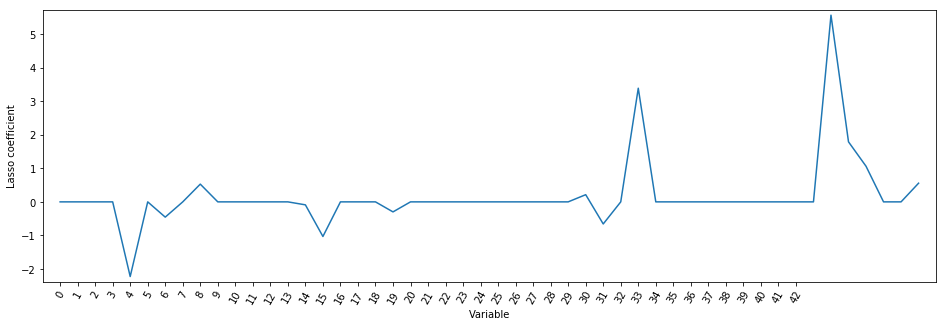

In [499]:
X_50 = data.iloc[:, 1:-1]
lasso_coef_50 = plot_lasso_coef(X_50,y)

In [515]:
print_vars(lasso_coef_50)

dengue!
#dengue
casa
acho
pode
hoje


lasso coefficients: 
 [ 0.10000708  0.          0.         -0.05302793 -1.53976277  0.
 -0.61074742  0.70225398  0.2723492  -0.          0.         -0.25756975
  0.         -0.         -0.         -0.         -0.          0.
 -0.026278   -0.52378596  0.          0.          2.41729681 -0.03392091
 -0.         -0.          0.19600019 -0.         -0.          0.09791373]


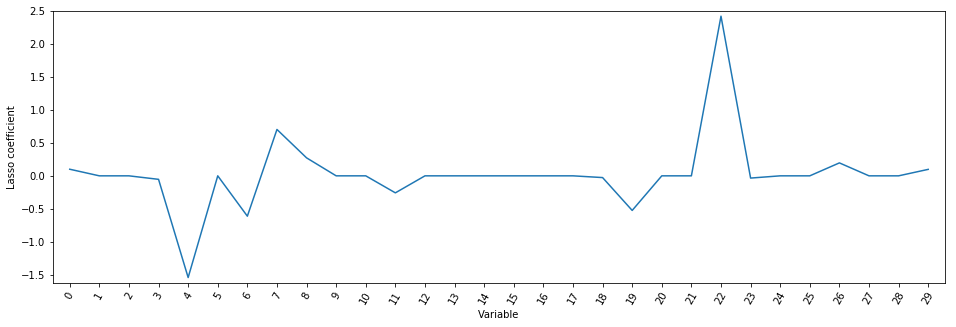

In [512]:
X_30 = data.iloc[:, 1:31]
lasso_coef_30 = plot_lasso_coef(X_30,y)

In [516]:
print_vars(lasso_coef_30)

dengue!
to


# draft

In [ ]:
text_test = [['this', 'is', 'a', 'sample'], ['this', 'is', 'another', 'example']]